#### Gaussian Discriminant Analysis for Classificating Marketing Target

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import multivariate_normal
from matplotlib.colors import ListedColormap

In [2]:
# Load Data
market_data = pd.read_csv('./dataset/Social_Network_Ads.csv', header=0)

# Remove the First Column
market_data = market_data.drop(market_data.columns[0], axis=1)

# Training Set
train_X = market_data.iloc[0:300, 0:-1].values
train_Y = market_data.iloc[0:300:, -1].values

# Test Set
test_X = market_data.iloc[300:, 0:-1].values
test_Y = market_data.iloc[300:, -1].values

# Standardize the Features for Both Training Set and Test Set
scaler = StandardScaler()

train_X = scaler.fit_transform(train_X)
test_X = scaler.transform(test_X)

# Transpose after Scaling
train_X = train_X.T
test_X = test_X.T

In [3]:
# Settings
data_dim, train_data_size = train_X.shape
test_data_size = test_X.shape[1]

# Swap 0s with 1s and 1s with 0s in Output Set for Summation of Indicator Functions
swapped_train_Y = np.where(train_Y==0, 1, 0) 
swapped_test_Y = np.where(test_Y==0, 1, 0)

In [4]:
# The Parameters of The GDA Model
prior_prob = 1 / train_data_size * np.sum(train_Y) #! φ = 1/n * ΣI(y^(i)=1)
mean_y0 = train_X @ swapped_train_Y / np.sum(swapped_train_Y) #! μ0 = ΣI(y^(i)=0) * x^(i) / ΣI(y^(i)=0)
mean_y1 = train_X @ train_Y / np.sum(train_Y) #! μ0 = ΣI(y^(i)=1) * x^(i) / ΣI(y^(i)=1)

# Reshape Means to Be Column Vectors
mean_y0 = mean_y0.reshape(-1, 1)
mean_y1 = mean_y1.reshape(-1, 1)

# Subtract Means from Input X Based on Corresponding Y
X_mu = train_X.copy()
X_mu[:, train_Y == 0] -= mean_y0 #! Σ = 1/n * Σ((x^(i) - μy^(i)) * (x^(i) - μy^(i))^T)
X_mu[:, train_Y == 1] -= mean_y1

covariance_matrix = (X_mu @ X_mu.T) / train_data_size

In [5]:
# Distributions for Two Classes
prob_y0 = 1- prior_prob
prob_y1 = prior_prob

# Calculate the Inverse and Determinant of the Covariance Matrix
covariance_matrix_inv = np.linalg.inv(covariance_matrix)
covariance_matrix_det = np.linalg.det(covariance_matrix)

# Constant Factor for the Multivariate Guassian Distribution
const_factor = 1 / ((2 * np.pi) ** (data_dim / 2) * np.sqrt(covariance_matrix_det))

# Subtract the Means from the Test Set
diff_y0 = test_X - mean_y0
diff_y1 = test_X - mean_y1

# Compute Exponential Part
exp_arg0 = np.sum((diff_y0.T @ covariance_matrix_inv) * diff_y0.T, axis=1)
exp_arg1 = np.sum((diff_y1.T @ covariance_matrix_inv) * diff_y1.T, axis=1)

# Compute the Probability Densities
p_x_given_y0 = const_factor * np.exp(-0.5 * exp_arg0) #! p(x|y=0) = (1 / (2π)^(n/2) * |Σ|^(1/2)) * exp(-1/2 * (x - μ0)^T * Σ^-1 * (x - μ0))
p_x_given_y1 = const_factor * np.exp(-0.5 * exp_arg1) #! p(x|y=1) = (1 / (2π)^(n/2) * |Σ|^(1/2)) * exp(-1/2 * (x - μ1)^T * Σ^-1 * (x - μ1))

In [6]:
# Predict the Classes Based on the Probability Densities
test_Y_hat = prob_y1 * p_x_given_y1 > prob_y0 * p_x_given_y0

# Print Classification Report
print(classification_report(test_Y, test_Y_hat, zero_division=0))

              precision    recall  f1-score   support

           0       0.60      0.95      0.73        38
           1       0.95      0.61      0.75        62

    accuracy                           0.74       100
   macro avg       0.77      0.78      0.74       100
weighted avg       0.82      0.74      0.74       100



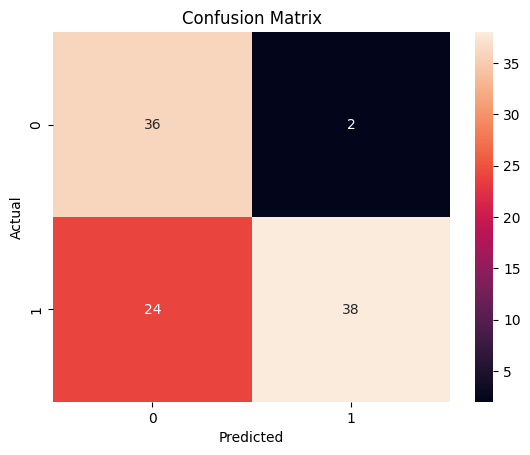

In [7]:
# Create Confusion Matrix
cm = confusion_matrix(test_Y, test_Y_hat)

# Plot Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

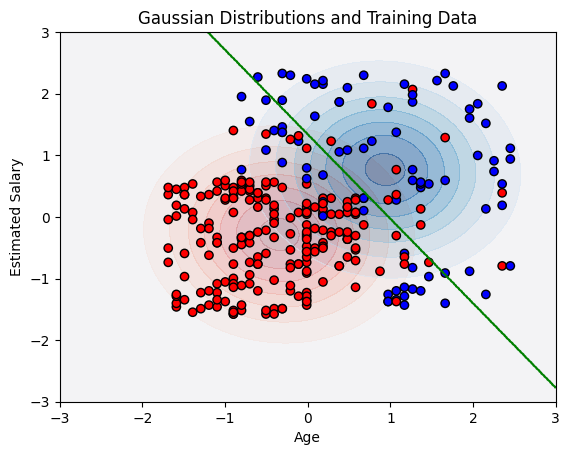

In [8]:
# Create Grid and Multivariate Normal Distributions
x = np.linspace(-3,3,500)
y = np.linspace(-3,3,500)
X, Y = np.meshgrid(x,y)
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X; pos[:, :, 1] = Y

# Mean Vector and Covariance Matrix for Class 0
mu0 = np.squeeze(mean_y0)
Sigma0 = covariance_matrix

# Mean Vector and Covariance Matrix for Class 1
mu1 = np.squeeze(mean_y1)
Sigma1 = covariance_matrix

# Create A Frozen RV Object for Each Class
rv0 = multivariate_normal(mu0, Sigma0)
rv1 = multivariate_normal(mu1, Sigma1)

# Calculate the Probabilities for Each Class on the Grid
prob_grid_y0 = prob_y0 * rv0.pdf(pos)
prob_grid_y1 = prob_y1 * rv1.pdf(pos)

# Create A Mask Where the Probability of Class 1 is Greater Than Class 0
decision_boundary = prob_grid_y1 > prob_grid_y0

# Define A Colormap for the Scatter Plot
cmap_scatter = ListedColormap(['red', 'blue'])

# Make A Contour Plot for Each Class
plt.contourf(X, Y, rv0.pdf(pos), alpha=0.5, cmap='Reds')
plt.contourf(X, Y, rv1.pdf(pos), alpha=0.5, cmap='Blues')

# Plot the Decision Boundary
plt.contour(X, Y, decision_boundary, colors='green')

# Define A Colormap
cmap = ListedColormap(['red', 'blue'])

# Plot the Data
plt.scatter(train_X[0, :], train_X[1, :], c=train_Y, cmap=cmap, edgecolors='k')

plt.xlabel('Age')
plt.ylabel('Estimated Salary')
plt.title('Gaussian Distributions and Training Data')
plt.show()
